# Quality assurance and quanlity control

## WAFS

In [78]:
import glob

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
import xarray as xr

plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.sans-serif": ["Computer Modern Roman"],
        "axes.grid": False,
        "savefig.dpi": 700,
        "figure.figsize": [8, 6],
        "font.size": 14,
    }
)
plt.style.use(["seaborn-colorblind"])
xr.set_options(display_expand_data=False)

### Single datasets

In [14]:
ds_wind_temp = xr.open_dataset(
    "../../pangeo_tools/wafs/wafs_[wind_temp]_20220630T060000Z_[20220630T150000Z].nc"
)
ds_ice = xr.open_dataset(
    "../../pangeo_tools/wafs/wafs_[ice]_20220630T060000Z_[20220630T150000Z].nc"
)
ds_turb = xr.open_dataset(
    "../../pangeo_tools/wafs/wafs_[turb]_20220630T060000Z_[20220630T150000Z].nc"
)

In [15]:
ds_wind_temp.lat

<xarray.DataArray 'lat' (lat: 721)>
-90.0 -89.75 -89.5 -89.25 -89.0 -88.75 ... 88.75 89.0 89.25 89.5 89.75 90.0
Coordinates:
  * lat      (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
Attributes:
    long_name:      Latitude
    standard_name:  latitude
    units:          degree_north
    dtype:          float32
    precision:      2
    valid_max:      90
    valid_min:      -90
    description:    
    notes:          [-90, 90]

In [16]:
ds_ice.lat

<xarray.DataArray 'lat' (lat: 721)>
-90.0 -89.75 -89.5 -89.25 -89.0 -88.75 ... 88.75 89.0 89.25 89.5 89.75 90.0
Coordinates:
  * lat      (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
Attributes:
    units:             degree_north
    standard_name:     latitude
    long_name:         Latitude
    stored_direction:  decreasing
    dtype:             float32
    precision:         2
    valid_max:         90
    valid_min:         -90
    description:       
    notes:             [-90, 90]

In [17]:
ds_turb.lat

<xarray.DataArray 'lat' (lat: 721)>
-90.0 -89.75 -89.5 -89.25 -89.0 -88.75 ... 88.75 89.0 89.25 89.5 89.75 90.0
Coordinates:
  * lat      (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
Attributes:
    units:             degree_north
    standard_name:     latitude
    long_name:         Latitude
    stored_direction:  decreasing
    dtype:             float32
    precision:         2
    valid_max:         90
    valid_min:         -90
    description:       
    notes:             [-90, 90]

In [18]:
ds_wind_temp.lon

<xarray.DataArray 'lon' (lon: 1440)>
-180.0 -179.8 -179.5 -179.2 -179.0 -178.8 ... 178.8 179.0 179.2 179.5 179.8
Coordinates:
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
Attributes:
    long_name:      Longitude
    standard_name:  longitude
    units:          degree_east
    dtype:          float32
    precision:      2
    valid_max:      180
    valid_min:      -180
    description:    
    notes:          [-180, 180]

In [19]:
ds_ice.lon

<xarray.DataArray 'lon' (lon: 1440)>
-180.0 -179.8 -179.5 -179.2 -179.0 -178.8 ... 178.8 179.0 179.2 179.5 179.8
Coordinates:
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
Attributes:
    long_name:      Longitude
    standard_name:  longitude
    units:          degree_east
    dtype:          float32
    precision:      2
    valid_max:      180
    valid_min:      -180
    description:    
    notes:          [-180, 180]

In [20]:
ds_turb.lon

<xarray.DataArray 'lon' (lon: 1440)>
-180.0 -179.8 -179.5 -179.2 -179.0 -178.8 ... 178.8 179.0 179.2 179.5 179.8
Coordinates:
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
Attributes:
    long_name:      Longitude
    standard_name:  longitude
    units:          degree_east
    dtype:          float32
    precision:      2
    valid_max:      180
    valid_min:      -180
    description:    
    notes:          [-180, 180]

In [21]:
ds_wind_temp.lev

<xarray.DataArray 'lev' (lev: 53)>
3e+03 4e+03 5e+03 6e+03 7e+03 8e+03 ... 5.1e+04 5.2e+04 5.3e+04 5.4e+04 5.5e+04
Coordinates:
  * lev      (lev) float32 3e+03 4e+03 5e+03 6e+03 ... 5.3e+04 5.4e+04 5.5e+04
Attributes:
    long_name:      Level of atmosphere
    standard_name:  level
    units:          ft
    valid_min:      0.0
    precision:      1
    dtype:          float32
    description:    Altitude of particular location in the atmosphere
    notes:          _FillValue=-9999

In [22]:
ds_ice.lev

<xarray.DataArray 'lev' (lev: 6)>
6e+03 1e+04 1.4e+04 1.8e+04 2.4e+04 3e+04
Coordinates:
  * lev      (lev) float32 6e+03 1e+04 1.4e+04 1.8e+04 2.4e+04 3e+04
Attributes:
    long_name:      Level of atmosphere
    standard_name:  level
    units:          ft
    valid_min:      0.0
    precision:      1
    dtype:          float32
    description:    Altitude of particular location in the atmosphere
    notes:          _FillValue=-9999

In [23]:
ds_turb.lev

<xarray.DataArray 'lev' (lev: 9)>
1e+04 1.4e+04 1.8e+04 2.4e+04 2.7e+04 3e+04 3.4e+04 3.9e+04 4.5e+04
Coordinates:
  * lev      (lev) float32 1e+04 1.4e+04 1.8e+04 ... 3.4e+04 3.9e+04 4.5e+04
Attributes:
    long_name:      Level of atmosphere
    standard_name:  level
    units:          ft
    valid_min:      0.0
    precision:      1
    dtype:          float32
    description:    Altitude of particular location in the atmosphere
    notes:          _FillValue=-9999

In [24]:
ds_wind_temp.air_temperature_aviation

<xarray.DataArray 'air_temperature_aviation' (lev: 53, lat: 721, lon: 1440)>
[55026720 values with dtype=float32]
Coordinates:
  * lev      (lev) float32 3e+03 4e+03 5e+03 6e+03 ... 5.3e+04 5.4e+04 5.5e+04
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * lat      (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
Attributes:
    forecast_time:    2022-06-30T15:00:00
    forecast_hour:    15
    batch_timestamp:  2022-06-30T06:00:00
    long_name:        Bulk air temperature
    standard_name:    air_temperature
    units:            deg C
    precision:        1
    dtype:            float32
    description:      Air temperature measured at a particular location in th...
    notes:            _FillValue=-9999

In [25]:
ds_wind_temp.air_temperature_aviation.values[0]

array([[-41.8, -41.8, -41.8, ..., -41.8, -41.8, -41.8],
       [-39.6, -39.6, -39.6, ..., -39.6, -39.6, -39.6],
       [-37.5, -37.5, -37.5, ..., -37.5, -37.5, -37.5],
       ...,
       [ -0.5,  -0.5,  -0.5, ...,  -0.5,  -0.5,  -0.5],
       [  0.6,   0.6,   0.6, ...,   0.6,   0.6,   0.6],
       [  1.7,   1.7,   1.7, ...,   1.7,   1.7,   1.7]], dtype=float32)

In [26]:
ds_wind_temp.wind_speed_aviation

<xarray.DataArray 'wind_speed_aviation' (lev: 53, lat: 721, lon: 1440)>
[55026720 values with dtype=float32]
Coordinates:
  * lev      (lev) float32 3e+03 4e+03 5e+03 6e+03 ... 5.3e+04 5.4e+04 5.5e+04
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * lat      (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
Attributes:
    forecast_time:    2022-06-30T15:00:00
    forecast_hour:    15
    batch_timestamp:  2022-06-30T06:00:00
    long_name:        Wind speed
    standard_name:    wind_speed
    units:            m s-1
    precision:        1
    dtype:            float32
    description:      Sustained wind speed measured at a particular location ...
    notes:            Always >= 0, _FillValue=-9999

In [27]:
ds_wind_temp.wind_speed_aviation.values[0]

array([[ 2.8,  2.8,  2.8, ...,  2.8,  2.8,  2.8],
       [ 3.1,  3.1,  3.1, ...,  3.1,  3.1,  3.1],
       [ 3.5,  3.5,  3.5, ...,  3.5,  3.5,  3.5],
       ...,
       [ 9.1,  9.1,  9.1, ...,  9.1,  9.1,  9.1],
       [11.7, 11.7, 11.7, ..., 11.7, 11.7, 11.7],
       [14.4, 14.4, 14.4, ..., 14.4, 14.4, 14.4]], dtype=float32)

In [28]:
ds_wind_temp.wind_direction_aviation

<xarray.DataArray 'wind_direction_aviation' (lev: 53, lat: 721, lon: 1440)>
[55026720 values with dtype=float32]
Coordinates:
  * lev      (lev) float32 3e+03 4e+03 5e+03 6e+03 ... 5.3e+04 5.4e+04 5.5e+04
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * lat      (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
Attributes:
    forecast_time:    2022-06-30T15:00:00
    forecast_hour:    15
    batch_timestamp:  2022-06-30T06:00:00
    long_name:        Wind direction (origin)
    standard_name:    wind_from_direction
    units:            degree
    valid_max:        359
    precision:        1
    dtype:            float32
    description:      Meteorological wind direction (defined as where the win...
    notes:            [0, 359], _FillValue=-9999

In [29]:
ds_wind_temp.wind_direction_aviation.values[0]

array([[ 75. ,  75. ,  75. , ...,  75. ,  75. ,  75. ],
       [224.8, 224.6, 224.4, ..., 225.4, 225.2, 225. ],
       [194.6, 194.4, 194.3, ..., 195. , 194.9, 194.7],
       ...,
       [122. , 122.4, 122.7, ..., 121. , 121.3, 121.7],
       [109.6, 109.9, 110.1, ..., 108.7, 109. , 109.3],
       [277.1, 277.1, 277.1, ..., 277.1, 277.1, 277.1]], dtype=float32)

In [30]:
ds_ice.icing_severity_index_aviation

<xarray.DataArray 'icing_severity_index_aviation' (lev: 6, lat: 721, lon: 1440)>
[6229440 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lev      (lev) float32 6e+03 1e+04 1.4e+04 1.8e+04 2.4e+04 3e+04
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
Attributes:
    forecast_time:    2022-06-30T15:00:00
    forecast_hour:    15
    batch_timestamp:  2022-06-30T06:00:00
    long_name:        Icing severity index
    standard_name:    icing_severity_index_aviation
    units:            index (number)
    valid_min:        -1
    valid_max:        4
    precision:        0
    dtype:            float32
    description:      A numerical index value from -1 to 4 that specifies the...
    notes:            Always >= -1 and <=4 and _FillValue=-9999

In [31]:
ds_turb.eddy_dissipation_rate_aviation

<xarray.DataArray 'eddy_dissipation_rate_aviation' (lev: 9, lat: 721, lon: 1440)>
[9344160 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 -90.0 -89.75 -89.5 -89.25 ... 89.25 89.5 89.75 90.0
  * lev      (lev) float32 1e+04 1.4e+04 1.8e+04 ... 3.4e+04 3.9e+04 4.5e+04
  * lon      (lon) float32 -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
Attributes:
    forecast_time:    2022-06-30T15:00:00
    forecast_hour:    15
    batch_timestamp:  2022-06-30T06:00:00
    long_name:        Eddy dissipation rate
    standard_name:    eddy_dissipation_rate_aviation
    units:            m2/3 s-1
    valid_min:        0.0
    valid_max:        1.0
    precision:        3
    dtype:            float32
    description:      Turbulence severity field measured at a particular loca...
    notes:            _FillValue=-9999

In [32]:
ds_turb.eddy_dissipation_rate_aviation.values[0]

array([[0.03, 0.03, 0.03, ..., 0.03, 0.03, 0.03],
       [0.04, 0.04, 0.04, ..., 0.04, 0.04, 0.04],
       [0.04, 0.04, 0.04, ..., 0.04, 0.04, 0.04],
       ...,
       [0.03, 0.03, 0.03, ..., 0.03, 0.03, 0.03],
       [0.03, 0.03, 0.03, ..., 0.03, 0.03, 0.03],
       [0.03, 0.03, 0.03, ..., 0.03, 0.03, 0.03]], dtype=float32)

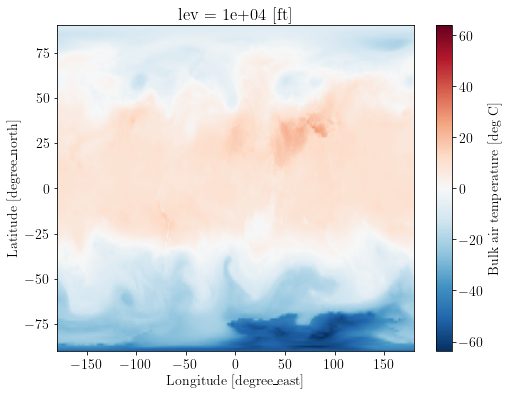

In [79]:
ds_wind_temp["air_temperature_aviation"].sel(lev=10000).plot();

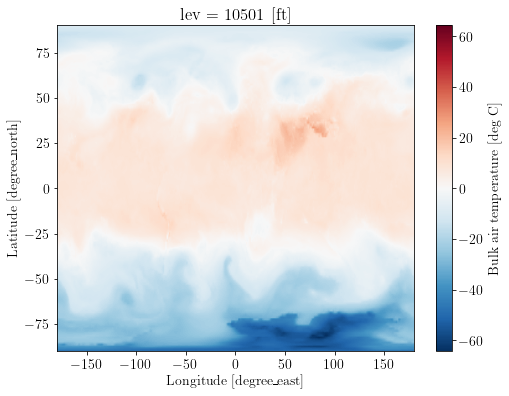

In [80]:
ds_wind_temp["air_temperature_aviation"].interp(
    lev=10501, kwargs={"fill_value": "extrapolate"}
).plot();

In [36]:
colors = {
    "icing_severity_index_aviation": [
        "#e06666",
        "#ffffff",
        "#eff3ff",
        "#bdd7e7",
        "#6baed6",
        "#2171b5",
    ],
    "eddy_dissipation_rate_aviation": [
        "#ffffff",
        "#ffffcc",
        "#ffeda0",
        "#fed976",
        "#feb24c",
        "#fd8d3c",
        "#fc4e2a",
        "#e31a1c",
        "#bd0026",
        "#800026",
    ],
}
levels = {
    "icing_severity_index_aviation": range(-1, 6),
    "eddy_dissipation_rate_aviation": np.linspace(0, 1.0, 11),
}

In [83]:
variable = "icing_severity_index_aviation"

In [84]:
ds_ice.lev.values

array([ 6000., 10000., 14000., 18000., 24000., 30000.], dtype=float32)

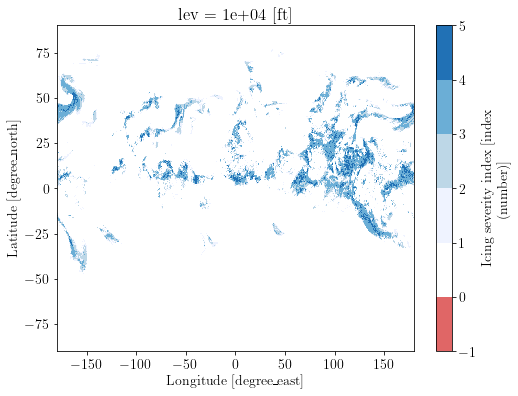

In [85]:
ds_ice[variable].sel(lev=10000).plot(levels=levels[variable], colors=colors[variable]);

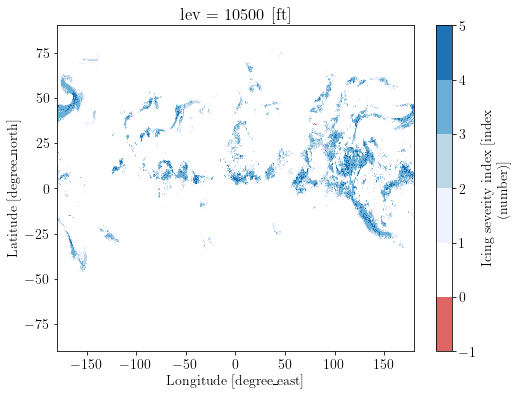

In [86]:
ds_ice[variable].interp(lev=10500, kwargs={"fill_value": "extrapolate"}).plot(
    levels=levels[variable], colors=colors[variable]
);

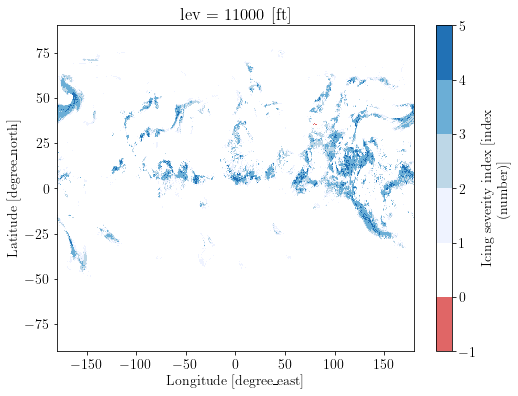

In [87]:
ds_ice[variable].interp(lev=11000, kwargs={"fill_value": "extrapolate"}).plot(
    levels=levels[variable], colors=colors[variable]
);

In [88]:
variable = "eddy_dissipation_rate_aviation"

In [89]:
ds_turb.lev.values

array([10000., 14000., 18000., 24000., 27000., 30000., 34000., 39000.,
       45000.], dtype=float32)

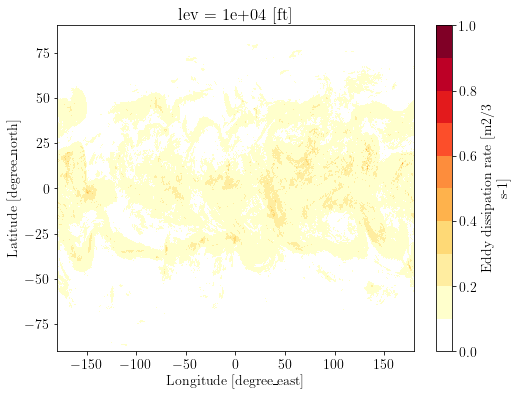

In [90]:
ds_turb[variable].sel(lev=10000).plot(levels=levels[variable], colors=colors[variable]);

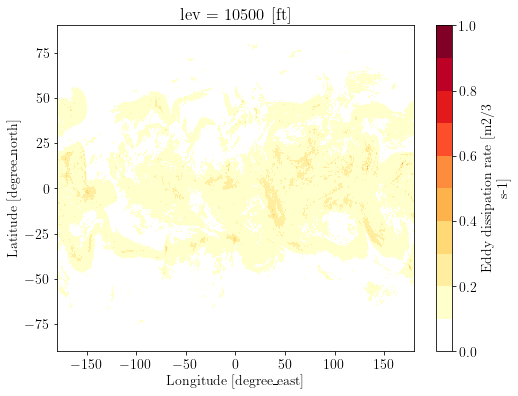

In [91]:
ds_turb[variable].interp(lev=10500, kwargs={"fill_value": "extrapolate"}).plot(
    levels=levels[variable], colors=colors[variable]
);

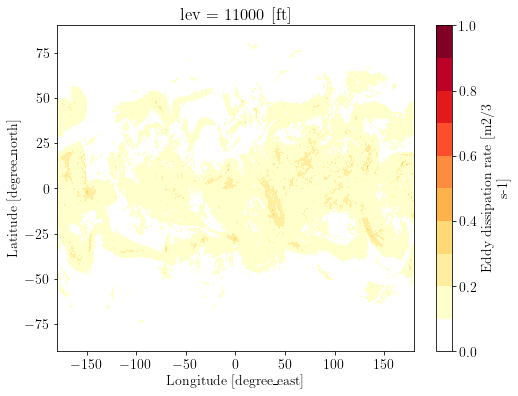

In [92]:
ds_turb[variable].interp(lev=11000, kwargs={"fill_value": "extrapolate"}).plot(
    levels=levels[variable], colors=colors[variable]
);

In [93]:
variables = set(ds_wind_temp.data_vars) | set(ds_ice.data_vars) | set(ds_turb.data_vars)

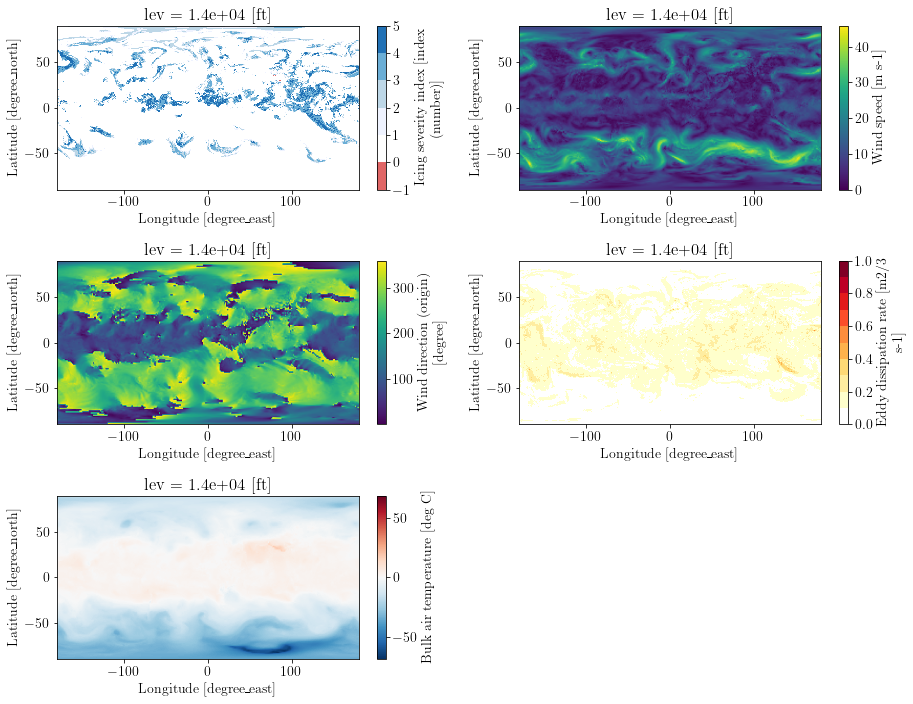

In [99]:
fig = plt.figure(1, figsize=(13, 10))
gs = gridspec.GridSpec(3, 2)

for index, variable in enumerate(variables):
    ax = fig.add_subplot(gs[index])
    if variable == "icing_severity_index_aviation":
        ds_ice[variable].sel(lev=14000).plot(
            ax=ax, levels=levels[variable], colors=colors[variable]
        )
    elif variable == "eddy_dissipation_rate_aviation":
        ds_turb[variable].sel(lev=14000).plot(
            ax=ax, levels=levels[variable], colors=colors[variable]
        )
    else:
        ds_wind_temp[variable].sel(lev=14000).plot(ax=ax)

plt.tight_layout()
plt.savefig('wafs_20220630T150000Z.png', facecolor="white", dpi=300, bbox_inches="tight")
plt.show()

### Merged datasets

In [63]:
wafs_files = glob.glob("../../pangeo_tools/wafs/wafs_*20220630T*.nc")

In [64]:
def add_time_coord_dim(ds: xr.Dataset) -> xr.Dataset:
    """Add time as a coordinate and dimension."""
    time = pd.to_datetime(ds.attrs["forecast_time"])
    ds = ds.assign_coords(time=time).expand_dims(dim="time")
    return ds

In [65]:
datasets = {}

for variable in ["wind_temp", "ice", "turb"]:
    wafs_files_variable = sorted([file for file in wafs_files if variable in file])
    datasets_variable = [
        add_time_coord_dim(xr.open_dataset(file)) for file in wafs_files_variable
    ]
    ds_combined_variable = xr.combine_by_coords(
        datasets_variable, combine_attrs="drop_conflicts"
    )
    datasets[variable] = ds_combined_variable

In [66]:
datasets

{'wind_temp': <xarray.Dataset>
 Dimensions:                   (time: 8, lev: 53, lat: 721, lon: 1440)
 Coordinates:
   * lev                       (lev) float32 3e+03 4e+03 ... 5.4e+04 5.5e+04
   * lon                       (lon) float32 -180.0 -179.8 -179.5 ... 179.5 179.8
   * lat                       (lat) float32 -90.0 -89.75 -89.5 ... 89.75 90.0
   * time                      (time) datetime64[ns] 2022-06-30 ... 2022-06-30...
 Data variables:
     air_temperature_aviation  (time, lev, lat, lon) float32 -49.7 ... -41.9
     wind_direction_aviation   (time, lev, lat, lon) float32 91.0 91.0 ... 295.8
     wind_speed_aviation       (time, lev, lat, lon) float32 2.0 2.0 ... 7.6 7.6
 Attributes:
     regrid_method:  bilinear
     title:          WAFS
     institution:    NOAA/NCEP
     version:        0.1.0,
 'ice': <xarray.Dataset>
 Dimensions:                        (lat: 721, lev: 6, lon: 1440, time: 8)
 Coordinates:
   * lat                            (lat) float32 -90.0 -89.75 ...

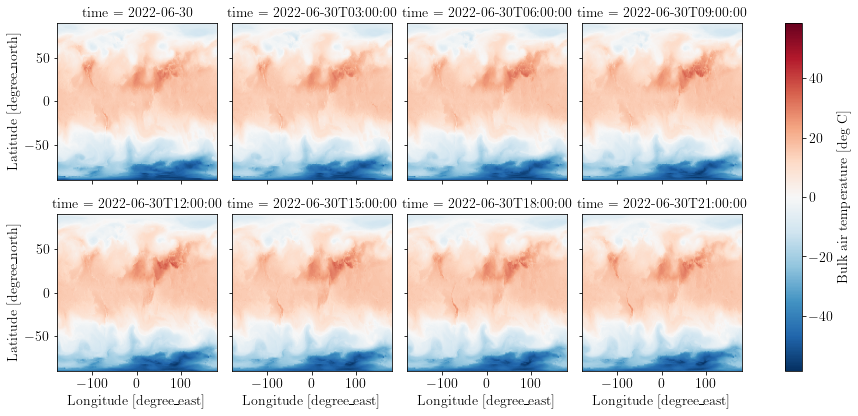

In [73]:
datasets["wind_temp"]["air_temperature_aviation"].isel(lev=3).plot(
    col="time",
    col_wrap=4,
);

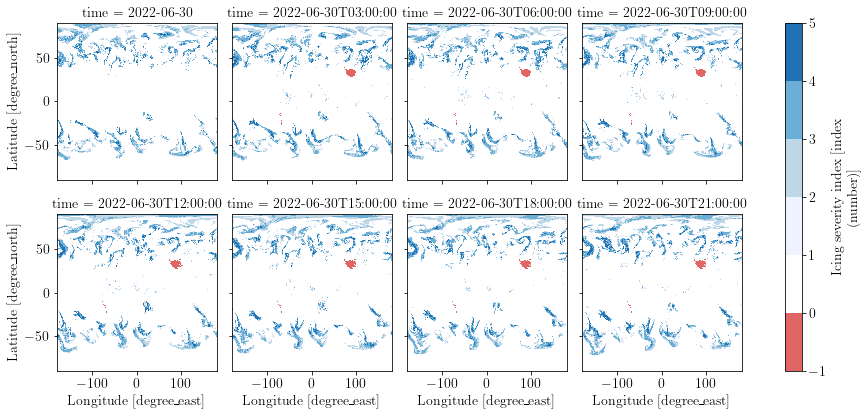

In [74]:
datasets["ice"]["icing_severity_index_aviation"].isel(lev=3).plot(
    col="time",
    col_wrap=4,
    levels=levels["icing_severity_index_aviation"],
    colors=colors["icing_severity_index_aviation"],
);

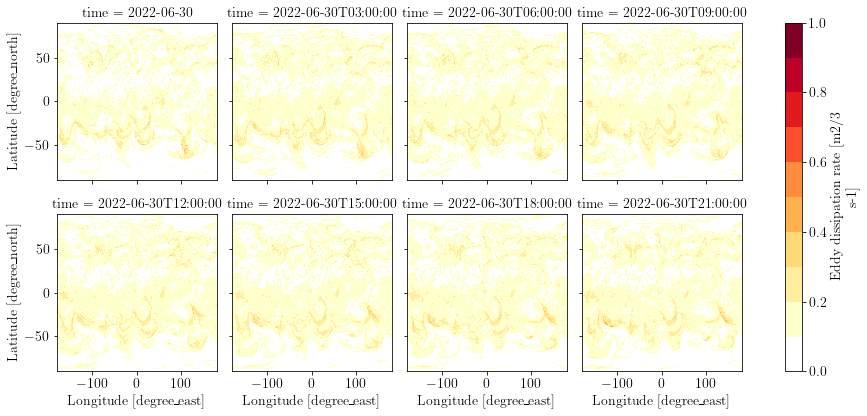

In [72]:
datasets["turb"]["eddy_dissipation_rate_aviation"].isel(lev=3).plot(
    col="time",
    col_wrap=4,
    levels=levels["eddy_dissipation_rate_aviation"],
    colors=colors["eddy_dissipation_rate_aviation"],
);